# Imports

In [0]:
from __future__ import print_function

import copy
import logging
import matplotlib.pyplot as plt
import numpy as np
import re
import tensorflow as tf
import warnings

from colabtools import publish
from tensor2tensor.utils import registry
from magenta.models import svg_vae
from magenta.models.svg_vae import svg_utils
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib


tfe = tf.contrib.eager
Modes = tf.estimator.ModeKeys


tf.enable_eager_execution()

logging.getLogger("mlperf_compliance").setLevel(logging.ERROR)
warnings.simplefilter("ignore")

# Code

## utils for initializing the model

In [0]:
def initialize_model(problem_name, data_dir, hparam_set, hparams, model_name,
                     ckpt_dir, split=Modes.TRAIN):
  """Returns an initialized model, dataset iterator and hparams."""
  tf.reset_default_graph()
  
  # create hparams and get glyphazzn problem definition
  hparams = trainer_lib.create_hparams(hparam_set, hparams, data_dir=data_dir,
                                       problem_name=problem_name)
  problem = registry.problem(problem_name)
  
  # get model definition
  ModelClass = registry.model(model_name)
  model = ModelClass(hparams, mode=Modes.PREDICT,
                     problem_hparams=hparams.problem_hparams)
  
  # create dataset iterator from problem definition
  dataset = problem.dataset(Modes.PREDICT, dataset_split=split,
                            data_dir=data_dir, shuffle_files=False,
                            hparams=hparams).batch(1)
  iterator = tfe.Iterator(dataset)
  
  # finalize/initialize model
  output, extra_losses = model(iterator.next())  # creates ops to be initialized
  model.initialize_from_ckpt(ckpt_dir)  # initializes ops
  
  return model, iterator, hparams

## utils for running the model with manipulated latent spaces

In [0]:
def get_bottleneck(features, model):
  """Retrieve latent encoding for given input pixel image in features dict."""
  features = features.copy()
  # the presence of a 'bottleneck' feature with 0 dimensions indicates that the
  # model should return the bottleneck from the input image
  features['bottleneck'] = tf.zeros((0, 128))
  return model(features)[0]


def infer_from_bottleneck(features, bottleneck, model, out='cmd'):
  """Returns a sample from a decoder, conditioned on the given a latent."""
  features = features.copy()
  
  # set bottleneck which we're decoding from
  features['bottleneck'] = bottleneck

  # reset inputs/targets. This guarantees that the decoder is only being
  # conditioned on the given bottleneck.
  batch_size = tf.shape(bottleneck)[:1].numpy().tolist()
  features['inputs'] = tf.zeros(
      batch_size + tf.shape(features['inputs'])[1:].numpy().tolist())
  features['targets'] = tf.zeros(
      batch_size + tf.shape(features['targets'])[1:].numpy().tolist())
  features['targets_psr'] = tf.zeros(
      batch_size + tf.shape(features['targets_psr'])[1:].numpy().tolist())
  
  if out == 'cmd':
    # using the SVG Decoder
    return model.infer(features, decode_length=0)
  # using the Image Decoder (from the Image VAE)
  return model(features)


def merge_features(features_list):
  new_features = {}
  for k in features_list[0].keys():
    all_vs = [features[k] for features in features_list]
    new_features[k] = tf.concat(all_vs, axis=0)
  return new_features

## utils for postprocessing svg htmls

In [0]:
start = ("""<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www."""
         """w3.org/1999/xlink" width="256px" height="256px" style="-ms-trans"""
         """form: rotate(360deg); -webkit-transform: rotate(360deg); transfo"""
         """rm: rotate(360deg);" preserveAspectRatio="xMidYMid meet" viewBox"""
         """="0 0 24 24"><path d=\"""")
end = """\" fill="currentColor"/></svg>"""

COMMAND_RX = re.compile("([MmLlHhVvCcSsQqTtAaZz])")
FLOAT_RX = re.compile("[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?")


def svg_html_to_path_string(svg):
  return svg.replace(start, '').replace(end, '')


def _tokenize(pathdef):
  """Returns each svg token from path list."""
  # e.g.: 'm0.1-.5c0,6' -> m', '0.1, '-.5', 'c', '0', '6'
  for x in COMMAND_RX.split(pathdef):
    if x != '' and x in 'MmLlHhVvCcSsQqTtAaZz':
      yield x
    for token in FLOAT_RX.findall(x):
      yield token


def path_string_to_tokenized_commands(path):
  """Tokenizes the given path string.

  E.g.:
      Given M 0.5 0.5 l 0.25 0.25 z
      Returns [['M', '0.5', '0.5'], ['l', '0.25', '0.25'], ['z']]
  """
  new_path = []
  current_cmd = []
  for token in _tokenize(path):
    if len(current_cmd) > 0:
      if token in 'MmLlHhVvCcSsQqTtAaZz':
        # cmd ended, convert to vector and add to new_path
        new_path.append(current_cmd)
        current_cmd = [token]
      else:
        # add arg to command
        current_cmd.append(token)
    else:
      # add to start new cmd
      current_cmd.append(token)

  if current_cmd:
    # process command still unprocessed
    new_path.append(current_cmd)

  return new_path


def separate_substructures(tokenized_commands):
  """Returns a list of SVG substructures."""
  # every moveTo command starts a new substructure
  # an SVG substructure is a subpath that closes on itself
  # such as the outter and the inner edge of the character `o`
  substructures = []
  curr = []
  for cmd in tokenized_commands:
    if cmd[0] in 'mM' and len(curr) > 0:
      substructures.append(curr)
      curr = []
    curr.append(cmd)
  if len(curr) > 0:
    substructures.append(curr)
  return substructures


def postprocess(svg, dist_thresh=2., skip=False):
  path = svg_html_to_path_string(svg)
  svg_template = svg.replace(path, '{}')
  tokenized_commands = path_string_to_tokenized_commands(path)
  
  dist = lambda a, b: np.sqrt((float(a[0]) - float(b[0]))**2 +
                              (float(a[1]) - float(b[1]))**2)
  are_close_together = lambda a, b, t: dist(a, b) < t
  
  # first, go through each start/end point and merge if they're close enough
  # together (that is, make end point the same as the start point).
  # TODO: there are better ways of doing this, in a way that propagates error
  # back (so if total error is 0.2, go through all N commands in this
  # substructure and fix each by 0.2/N (unless they have 0 vertical change))
  substructures = separate_substructures(tokenized_commands)
  previous_substructure_endpoint = (0., 0.,)
  for substructure in substructures:
    # first, if the last substructure's endpoint was updated, we must update
    # the start point of this one to reflect the opposite update
    substructure[0][-2] = str(float(substructure[0][-2]) -
                              previous_substructure_endpoint[0])
    substructure[0][-1] = str(float(substructure[0][-1]) -
                              previous_substructure_endpoint[1])
    
    start = list(map(float, substructure[0][-2:]))
    curr_pos = (0., 0.)
    for cmd in substructure:
      curr_pos, _ = svg_utils._update_curr_pos(curr_pos, cmd, (0., 0.))
    if are_close_together(start, curr_pos, dist_thresh):
      new_point = np.array(start)
      previous_substructure_endpoint = ((new_point[0] - curr_pos[0]),
                                        (new_point[1] - curr_pos[1]))
      substructure[-1][-2] = str(float(substructure[-1][-2]) +
                                 (new_point[0] - curr_pos[0]))
      substructure[-1][-1] = str(float(substructure[-1][-1]) +
                                 (new_point[1] - curr_pos[1]))
      if substructure[-1][0] in 'cC':
        substructure[-1][-4] = str(float(substructure[-1][-4]) +
                                   (new_point[0] - curr_pos[0]))
        substructure[-1][-3] = str(float(substructure[-1][-3]) +
                                   (new_point[1] - curr_pos[1]))
      
  if skip:
    return svg_template.format(' '.join([' '.join(' '.join(cmd) for cmd in s)
                                         for s in substructures]))
  
  cosa = lambda x, y: (x[0] * y[0] + x[1] * y[1]) / (
      (np.sqrt(x[0]**2 + x[1]**2) * np.sqrt(y[0]**2 +  y[1]**2)))
  rotate = lambda a, x, y: (x * np.cos(a) - y * np.sin(a),
                            y * np.cos(a) + x * np.sin(a))
  # second, gotta find adjacent bezier curves and, if their control points
  # are well enough aligned, fully align them
  for substructure in substructures:
    curr_pos = (0., 0.)
    new_curr_pos, _ = svg_utils._update_curr_pos((0., 0.,),
                                                 substructure[0], (0., 0.))
    
    for cmd_idx in range(1, len(substructure)):
      prev_cmd = substructure[cmd_idx-1]
      cmd = substructure[cmd_idx]
      
      new_new_curr_pos, _ = svg_utils._update_curr_pos(
          new_curr_pos, cmd, (0., 0.))
      
      if cmd[0] == 'c':
        if prev_cmd[0] == 'c':
          # check the vectors and update if needed
          # previous control pt wrt new curr point
          prev_ctr_point = (curr_pos[0] + float(prev_cmd[3]) - new_curr_pos[0],
                            curr_pos[1] + float(prev_cmd[4]) - new_curr_pos[1])
          ctr_point = (float(cmd[1]), float(cmd[2]))

          if -1. < cosa(prev_ctr_point, ctr_point) < -0.95:
            # calculate exact angle between the two vectors
            angle_diff = (np.pi - np.arccos(cosa(prev_ctr_point, ctr_point)))/2
            
            # rotate each vector by angle/2 in the correct direction for each.
            sign = np.sign(np.cross(prev_ctr_point, ctr_point))
            new_ctr_point = rotate(sign * angle_diff, *ctr_point)
            new_prev_ctr_point = rotate(-sign * angle_diff, *prev_ctr_point)
            
            # override the previous control points
            # (which has to be wrt previous curr position)
            substructure[cmd_idx-1][3] = str(new_prev_ctr_point[0] -
                                             curr_pos[0] + new_curr_pos[0])
            substructure[cmd_idx-1][4] = str(new_prev_ctr_point[1] -
                                             curr_pos[1] + new_curr_pos[1])
            substructure[cmd_idx][1] = str(new_ctr_point[0])
            substructure[cmd_idx][2] = str(new_ctr_point[1])

      curr_pos = new_curr_pos
      new_curr_pos = new_new_curr_pos
  
  return svg_template.format(' '.join([' '.join(' '.join(cmd) for cmd in s)
                                       for s in substructures]))

## utils for rendering model vector outputs into html svg

In [0]:
means_stdevs = {}

def get_means_stdevs(data_dir):
  """Returns the means and stdev saved in data_dir."""
  if data_dir not in means_stdevs:
    with tf.gfile.Open(os.path.join(data_dir, 'mean.npz'), 'r') as f:
      mean_npz = np.load(f)
    with tf.gfile.Open(os.path.join(data_dir, 'stdev.npz'), 'r') as f:
      stdev_npz = np.load(f)
    means_stdevs[data_dir] = (mean_npz, stdev_npz)
  return means_stdevs[data_dir]


def render(tensor, data_dir):
  """Converts SVG decoder output into HTML svg."""
  # undo normalization
  mean_npz, stdev_npz = get_means_stdevs(data_dir)
  tensor = (tensor * stdev_npz) + mean_npz

  # convert to html
  tensor = svg_utils.make_simple_cmds_long(tensor)
  vector = tf.squeeze(tensor, [0, 2])
  html = svg_utils.vector_to_svg(vector.numpy(), stop_at_eos=True,
                                 categorical=True)

  # some aesthetic postprocessing
  html = postprocess(html)
  html = html.replace('256px', '50px')
    
  return html

## utils for rendering, specific to colab

In [0]:
def prettify_ax(ax):
  ax.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_yticks([])
  ax.set_xticks([])


class OutputStream(object):
  """Defines how results are rendered in this colab: plt.Axes or html str."""

  def __init__(self, out, num_rows, num_cols, data_dir):
    self.num_cols = num_cols
    self.out = out
    self.data_dir = data_dir
    self.ax_id = 0
    if out == 'img':
      fig, self.axes = plt.subplots(num_rows, 2 + num_cols,
                                    figsize=(8 * num_cols / 10., 2))
      fig.subplots_adjust(left=0, top=1, bottom=0, right=1, wspace=0, hspace=0)
      self.axes = self.axes.flatten()
      for ax in self.axes:
        prettify_ax(ax)
    else:
      self.result_html = ''

  def add_output(self, new_output):
    if out == 'img':
      self.axes[self.ax_id].imshow(np.reshape(new_output, [64, 64]),
                                   vmin=0, vmax=1, cmap='gray')
    else:
      self.result_html += render(new_output, self.data_dir)
      self.maybe_add_br()
    self.ax_id += 1

  def add_spacing(self):
    if out == 'cmd':
      self.result_html += '&nbsp;' * 15

  def add_white(self):
    if out == 'img':
      self.add_output(np.ones([64, 64]))
    else:
      self.result_html += ('<div style="display:inline-block; '
                           'height: 50px; width: 50px;"></div>')
      self.maybe_add_br()
      self.ax_id += 1

  def maybe_add_br(self):
    if self.num_cols != 1 and (self.ax_id + 1) % (self.num_cols + 2) == 0:
        self.result_html += '<br />'

  def show(self):
    if out == 'img':
      plt.show()
    else:
      publish.html(self.result_html)


def _tile(features, key, dims):
  """Helper that creates copies of features['keys'] across given dims."""
  features[key] = tf.tile(features[key], dims)
  return features

## experiments with manipulating latent spaces

In [0]:
def class_switch(problem_name, data_dir, hparam_set, hparams, model_name,
                 ckpt_dir, out='cmd', split=Modes.TRAIN, ex_id=297):
  """Decodes one example of each class, conditioned on ex_id-th example."""
  model, iterator, hparams = initialize_model(
      problem_name, data_dir, hparam_set, hparams, model_name,
      ckpt_dir, split=split)
  
  num_classes = hparams.num_categories
  
  # get the ex_id-th example from the dataset
  for i in range(ex_id):
    features1 = iterator.next()
    
  # create output_steam
  output_stream = OutputStream(out, 3, 26, data_dir)
  output_stream.add_output(features1['inputs'])
  output_stream.add_white()

  # get bottleneck of the features we selected before
  bottleneck1 = get_bottleneck(features1, model)
  bottleneck1 = tf.tile(bottleneck1, [num_classes, 1])
  
  # create class batch
  new_features = copy.copy(features1)
  clss_batch = tf.reshape([tf.constant([[clss]], dtype=tf.int64)
                           for clss in range(num_classes)], [-1, 1])
  new_features['targets_cls'] = clss_batch
  new_features = _tile(new_features, 'targets_psr', [num_classes, 1, 1])
  inp_target_dim = [num_classes, 1, 1, 1] if out == 'cmd' else [num_classes, 1]
  new_features = _tile(new_features, 'inputs', inp_target_dim)
  new_features = _tile(new_features, 'targets', inp_target_dim)
  
  # run model
  output_batch = infer_from_bottleneck(
      new_features, bottleneck1, model, out=out)
  
  should_add_white = {12: 18, 56: 2}

  # render outputs and show results
  output_batch = output_batch[0] if out == 'img' else output_batch['outputs']
  for output in tf.split(output_batch, num_classes):
    output_stream.add_output(output)

    if output_stream.ax_id in should_add_white.keys():
      [output_stream.add_white()
       for _ in range(should_add_white[output_stream.ax_id])]
  output_stream.show()


def interpolation(problem_name, data_dir, hparam_set, hparams, model_name,
                  ckpt_dir, out='cmd', split=Modes.TRAIN,
                  ex_id=297, ex_id2=110):
  """Interpolates between two given icons in the dataset."""
  model, iterator, hparams = initialize_model(
      problem_name, data_dir, hparam_set, hparams, model_name,
      ckpt_dir, split=split)
  
  # get both latent spaces we will interpolate
  for i in range(ex_id):
    features1 = iterator.next()
  bottleneck1 = get_bottleneck(features1, model)
  
  for i in range(ex_id2):
    features2 = iterator.next()
  bottleneck2 = get_bottleneck(features2, model)

  interpolation_weights = np.linspace(0, 1, 11, dtype=np.float32)

  # show first latent's input
  output_stream = OutputStream(out, 1, len(interpolation_weights), data_dir)
  output_stream.add_output(features1['inputs'])
  output_stream.add_spacing()

  # prepare batch so we can get all interpolations in one go
  num_batch = len(interpolation_weights)
  new_features = copy.copy(features1)
  all_bottlenecks = [(bottleneck1 + alpha * (bottleneck2 - bottleneck1))
                     for alpha in interpolation_weights]
  all_bottlenecks = tf.reshape(all_bottlenecks, [num_batch, -1])
  inputs_targets_dim = [num_batch, 1, 1, 1] if out == 'cmd' else [num_batch, 1]
  new_features = _tile(new_features, 'inputs', inputs_targets_dim)
  new_features = _tile(new_features, 'targets', inputs_targets_dim)
  new_features = _tile(new_features, 'targets_cls', [num_batch, 1])
  new_features = _tile(new_features, 'targets_psr', [num_batch, 1, 1])

  # run the decoder, conditioned on the bottleneck.
  output_batch = infer_from_bottleneck(
      new_features, all_bottlenecks, model, out=out)

  # render outputs
  output_batch = output_batch[0] if out == 'img' else output_batch['outputs']
  for output in tf.split(output_batch, num_batch):
    output_stream.add_output(output)

  if 'targets_cls' in features1:
    print('cls={}'.format(features1['targets_cls'][0][0]))

  # add final image (direction towards which we were interpolating) and show
  output_stream.add_spacing()
  output_stream.add_output(features2['inputs'])
  output_stream.show()


def random_bottleneck(problem_name, data_dir, hparam_set, hparams, model_name,
                      ckpt_dir, out='cmd'):
  """Decodes one example per class given randomly-sampled bottlenecks."""
  model, iterator, hparams = initialize_model(
      problem_name, data_dir, hparam_set, hparams, model_name, ckpt_dir)

  num_classes = hparams.num_categories
    
  # create randomly-sampled bottleneck
  features1 = iterator.next()
  bottleneck_shape = [num_classes,
                      tf.shape(get_bottleneck(features1, model))[-1]]
  bottleneck1 = tf.random_normal(bottleneck_shape)
  
  # create output_steam
  output_stream = OutputStream(out, 3, num_classes//3 + 4, data_dir)

  # prepare batch so we can get all classes in one go
  new_features = copy.copy(features1)
  clss_batch = tf.reshape([tf.constant([[clss]], dtype=tf.int64)
                           for clss in range(num_classes)], [-1, 1])
  new_features['targets_cls'] = clss_batch
  new_features = _tile(new_features, 'targets_psr', [num_classes, 1, 1])
  inp_target_dim = [num_classes, 1, 1, 1] if out == 'cmd' else [num_classes, 1]
  new_features = _tile(new_features, 'inputs', inp_target_dim)
  new_features = _tile(new_features, 'targets', inp_target_dim)

  # run model
  output_batch = infer_from_bottleneck(
      new_features, bottleneck1, model, out=out)
  
  # render outputs and show results
  output_batch = output_batch[0] if out == 'img' else output_batch['outputs']
  for output in tf.split(output_batch, num_classes):
    output_stream.add_output(output)
    if output_stream.ax_id == 10:
      [output_stream.add_white() for _ in range(16)]
  
  output_stream.show()

# Running

class switch


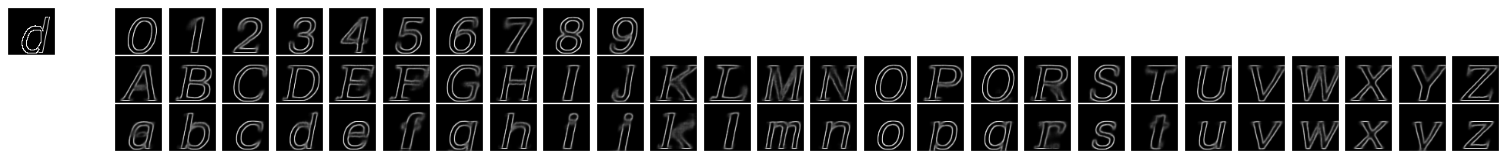

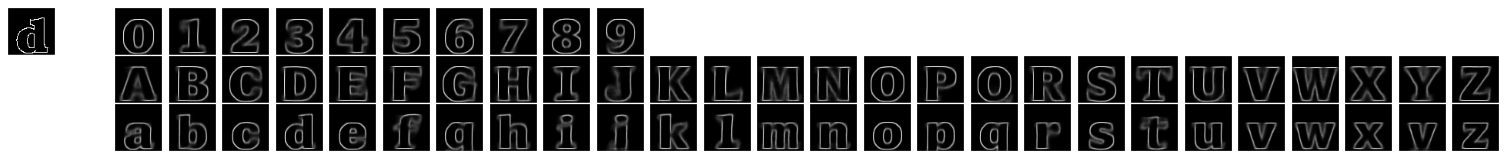

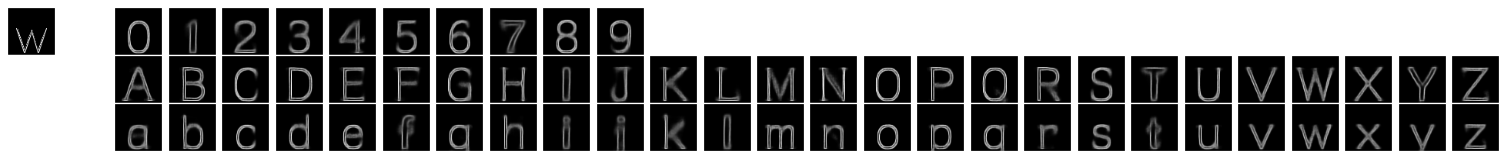

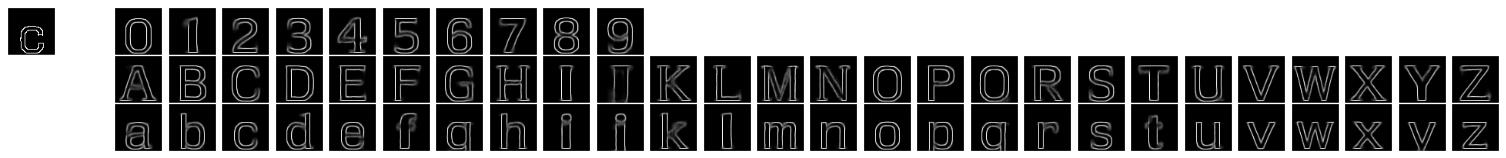

interpolation
cls=39


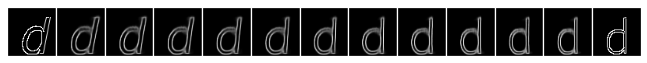

cls=10


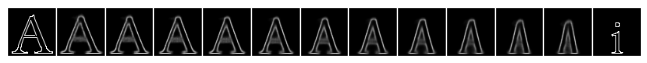

random z per class


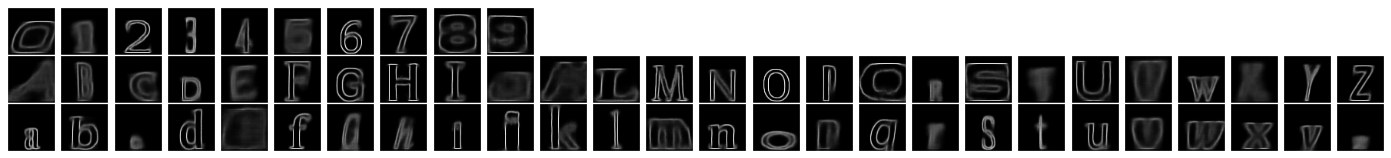

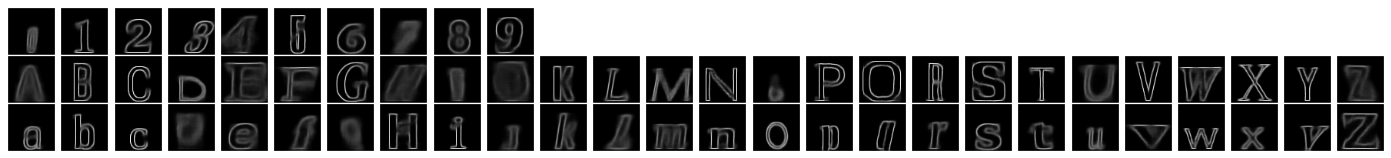

In [0]:
# vae trained on external data, tested with external data
problem = 'glyph_azzn_problem'
data_dir = '/path/to/external_data/'
model_name = 'image_vae'  # or svg_decoder
hparam_set = 'image_vae'  # or svg_decoder
hparams = ""
ckpt_dir = '/path/to/image_vae_external/'
out = 'img' if model_name == 'image_vae' else 'cmd'

print('class switch')
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=101)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=103)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=165)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=195)

print('interpolation')
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=101, ex_id2=(102-101))
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=96, ex_id2=(172-96))

print('random z per class')
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)

class switch


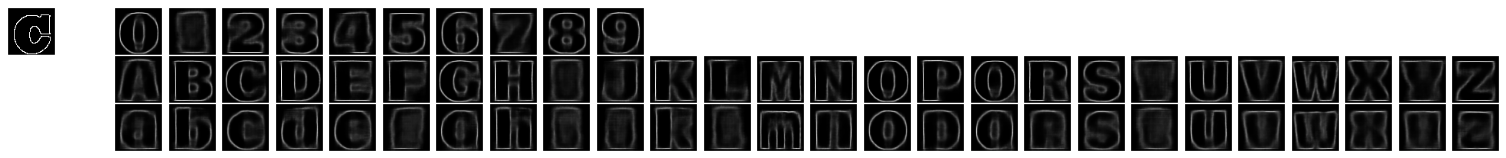

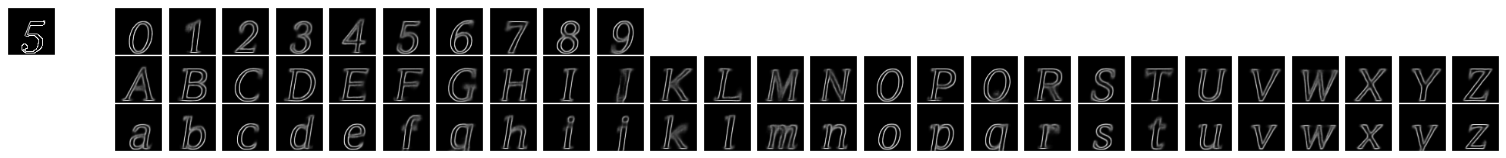

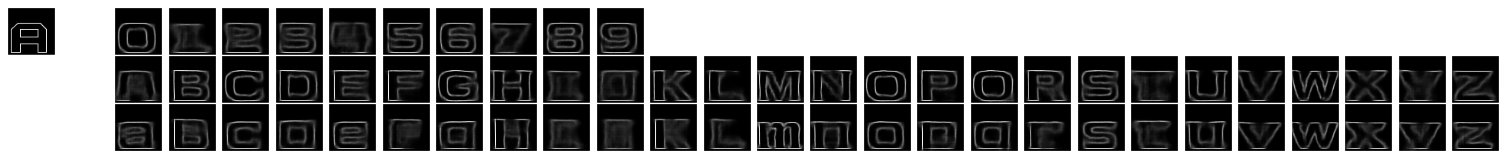

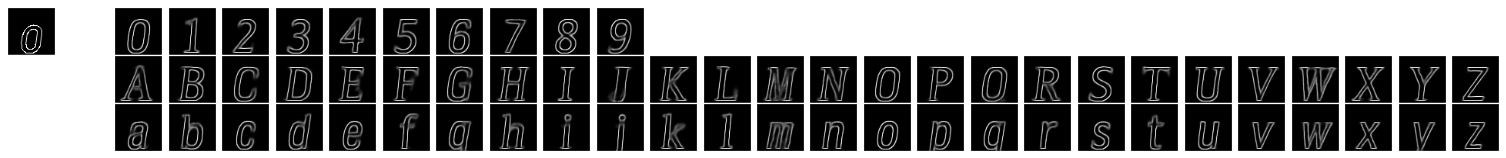

interpolation
cls=38


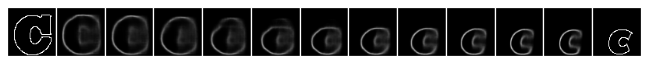

cls=14


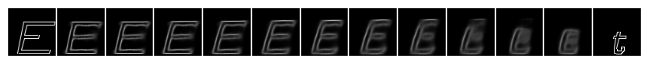

random z per class


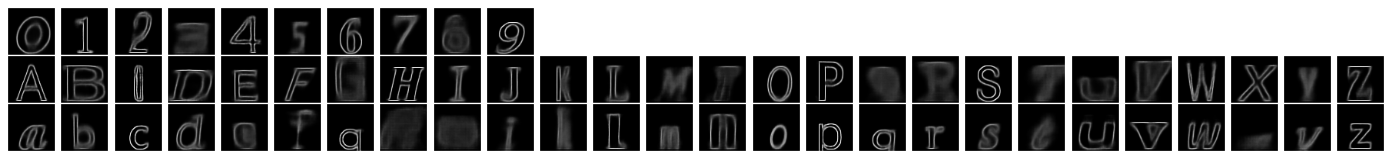

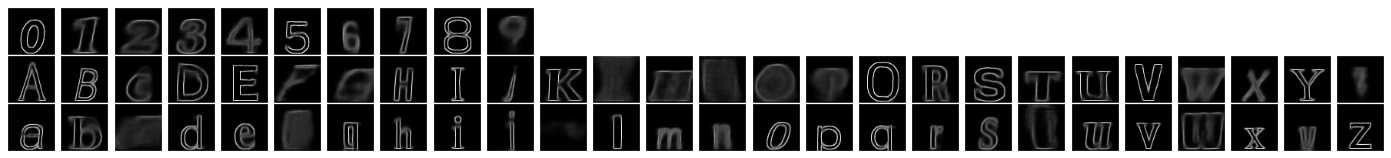

In [0]:
# vae trained on internal data, tested with internal data
problem = 'glyph_azzn_problem'
data_dir = '/path/to/internal_data/'
model_name = 'image_vae'  # or svg_decoder
hparam_set = 'image_vae'  # or svg_decoder
hparams = ""
ckpt_dir = '/path/to/image_vae_internal/'
out = 'img' if model_name == 'image_vae' else 'cmd'

print('class switch')
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=131)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=120)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=68)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=69)


print('interpolation')
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=131, ex_id2=(184-131))
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=172, ex_id2=(198-172))

print('random z per class')
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)

class switch


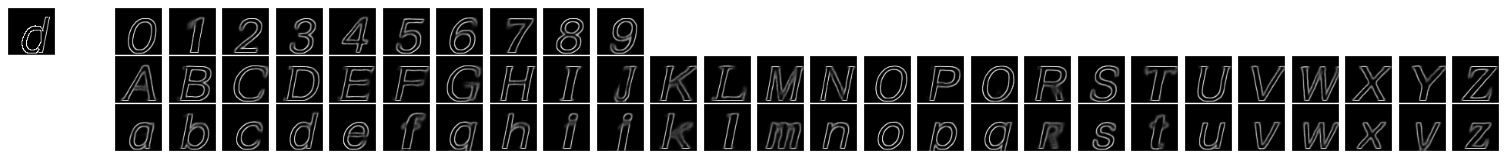

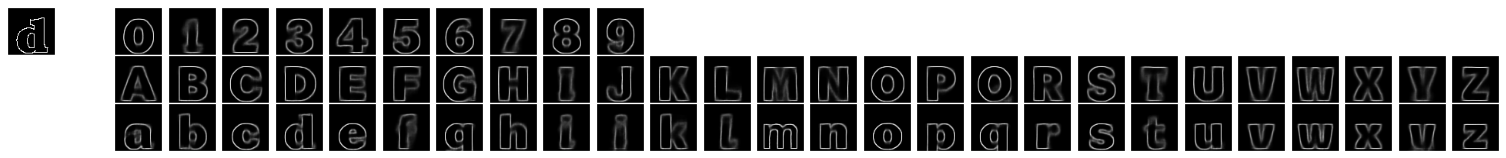

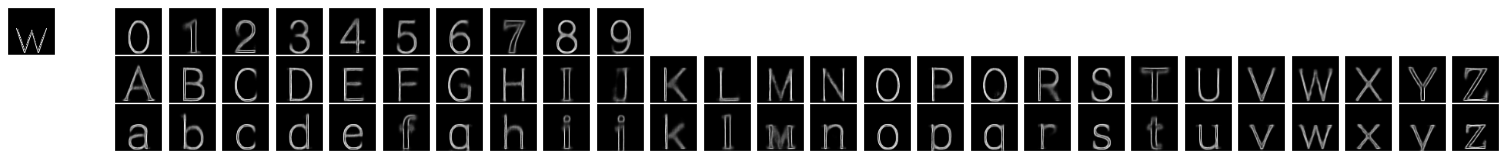

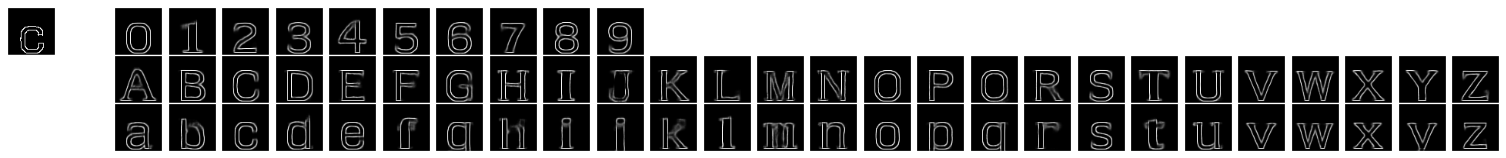

interpolation
cls=39


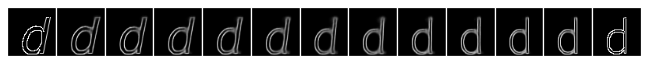

cls=10


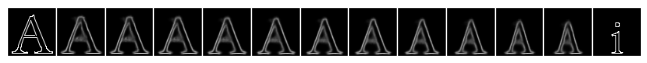

random z per class


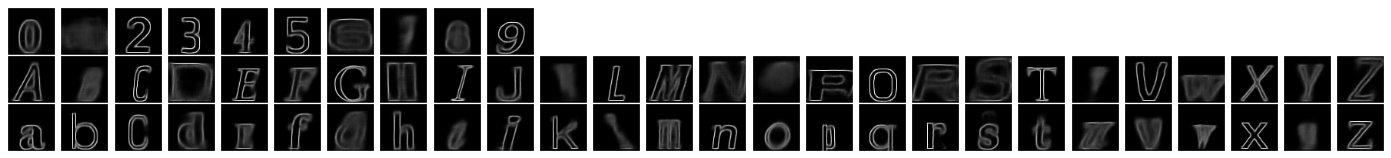

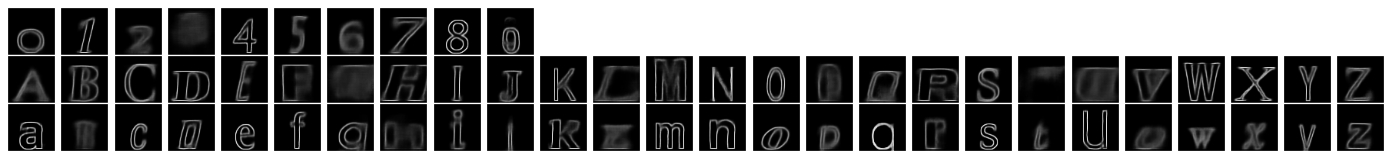

In [0]:
# vae trained on internal data, tested with external data
problem = 'glyph_azzn_problem'
data_dir = '/path/to/external_data/'
model_name = 'image_vae'  # or svg_decoder
hparam_set = 'image_vae'  # or svg_decoder
hparams = ""
ckpt_dir = '/path/to/image_vae_internal/'
out = 'img' if model_name == 'image_vae' else 'cmd'

print('class switch')
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=101)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=103)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=165)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=195)

print('interpolation')
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=101, ex_id2=(102-101))
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=96, ex_id2=(172-96))

print('random z per class')
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)

In [0]:
# svg trained on external data, tested with external data
problem = 'glyph_azzn_problem'
data_dir = '/path/to/external_data/'
model_name = 'svg_decoder'  # or image_vae
hparam_set = 'svg_decoder'  # or image_vae
hparams = ("vae_ckpt_dir=/path/to/image_vae_external,"
           "vae_data_dir=/path/to/external_data,vae_hparam_set=image_vae")
ckpt_dir = '/path/to/svg_decoder_external'
out = 'cmd'

# you can control sampling variance by changing the temperatures here
new_hparams = 'mix_temperature={},gauss_temperature={}'.format(0.0001, 0.0001)
hparams = hparams + ',' + new_hparams
print('using {}'.format(new_hparams))

print('class switch')
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=101)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=103)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=165)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=195)

print('interpolation')
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=101, ex_id2=(102-101))
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=96, ex_id2=(172-96))

print('random z per class')
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)

using mix_temperature=0.0001,gauss_temperature=0.0001
class switch


interpolation
cls=39


cls=10


random z per class


In [0]:
# svg trained on internal data, tested with internal data
problem = 'glyph_azzn_problem'
data_dir = '/path/to/internal_data/'
model_name = 'svg_decoder'  # or image_vae,
hparam_set = 'svg_decoder'  # or image_vae,
hparams = ("vae_ckpt_dir=/path/to/image_vae_internal,"
           "vae_data_dir=/path/to/internal_data,vae_hparam_set=image_vae")
ckpt_dir = '/path/to/svg_decoder_internal'
out = 'cmd'

# you can control sampling variance by changing the temperatures here
new_hparams = 'mix_temperature={},gauss_temperature={}'.format(0.0001, 0.0001)
hparams = hparams + ',' + new_hparams
print('using {}'.format(new_hparams))

print('class switch')
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=131)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=120)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=68)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=69)


print('interpolation')
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=131, ex_id2=(184-131))
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=172, ex_id2=(198-172))

print('random z per class')
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)

using mix_temperature=0.0001,gauss_temperature=0.0001
class switch


interpolation
cls=38


cls=14


random z per class


In [0]:
# svg trained on internal data, tested with external data
problem = 'glyph_azzn_problem'
data_dir = '/path/to/external_data/'
model_name = 'svg_decoder'  # or image_vae,
hparam_set = 'svg_decoder'  # or image_vae,
hparams = ("vae_ckpt_dir=/path/to/image_vae_internal,"
           "vae_data_dir=/path/to/internal_data,vae_hparam_set=image_vae")
ckpt_dir = '/path/to/svg_decoder_internal'
out = 'cmd'

# you can control sampling variance by changing the temperatures here
new_hparams = 'mix_temperature={},gauss_temperature={}'.format(0.0001, 0.0001)
hparams = hparams + ',' + new_hparams
print('using {}'.format(new_hparams))

print('class switch')
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=101)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=103)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=165)
class_switch(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
             out=out, split=Modes.TRAIN, ex_id=195)

print('interpolation')
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=101, ex_id2=(102-101))
interpolation(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
              out=out, ex_id=96, ex_id2=(172-96))

print('random z per class')
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)
random_bottleneck(problem, data_dir, hparam_set, hparams, model_name, ckpt_dir,
                  out=out)

using mix_temperature=0.0001,gauss_temperature=0.0001
class switch


interpolation
cls=39


cls=10


random z per class
